# Implement probabilistic scores for ensemble forecasts
 
Now let's implement the ensemble scores. Please refer to the Dropbox document for their definition. 

1. Spread/Skill ratio: As mentioned in Scher and Messori (2020) there is a right way to do the order of the computations. Read their paragraph on it.
2. CRPS: Try the `properscoring` package. This one should be good.
3. Rank histogram: Try the `rankhistogram` package. No idea if this one is good. If it's ok but requires minor changes, we can consider a pull request. Otherwise, let's just write our own implementation. 

For all three scores:
- Use `xarray` as much as possible. Write a function similar to `src.score.compute_weighted_rmse.py`. 
- Ignore the weighted part at first.
- Create simple synthetic datasets to test extreme cases. E.g. `ensemble = [1, 1, 1]`, `obs=[1]` should result in a CRPS of 0. Think about what good sanity checks are for each score. For the rank histogram, for example, try to build examples that should end up in the shapes from the Dropbox document (overdispersion, underdispersion, etc.)
- Test the three functions with the "real" data from the dropout ensemble.
- Now the weighted part: Because the area of each lat-lon square is not the same but in fact varies with cos(lat), we want to weigh each grid point proportional to its area. This is already implemented for the rmse and acc scores in `src/score.py`. Implement this for the three probabilistic scores and compare to the unweighted scores. They shouldn't be too different. Implementing this for the rank histogram might require some thinking. We can talk about this together.

ToDo:
- make crps work for full data. try loading in batches.
- see rank histogram. maybe can make it faster.

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
from src.train import *
import matplotlib.pyplot as plt

In [12]:
# # You only need this if you are using a GPU
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
limit_mem()

/home/garg/miniconda3/envs/weatherbench/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [13]:
tf.__version__
!pwd

/home/garg/WeatherBench/nbs_probabilistic


In [14]:
#exp_id_path='/home/garg/WeatherBench/nn_configs/B/82-resnet_d3_dr_0.2.yml'
model_save_dir='/home/garg/data/WeatherBench/predictions/saved_models'
datadir='/home/garg/data/WeatherBench/5.625deg'
pred_save_dir='/home/garg/data/WeatherBench/predictions'

In [15]:
!ls $pred_save_dir

01-resnet_baseline.nc	   81.2-resnet_d3_dr_0.1.nc
02-resnet_2dt.nc	   81.3-resnet_d3_dr_0.1.nc
100-resnet_d3_param.nc	   81-resnet_d3_dr_0.1_fixed.nc
105-resnet_d3_dr_0.5.nc    81-resnet_d3_dr_0.1.nc
80.1-resnet_d3_dr_0.05.nc  82.1-resnet_d3_dr_0.2.nc
80-resnet_d3_dr_0.05.nc    82-resnet_d3_dr_0.2.nc
81.1-resnet_d3_dr_0.1.nc   saved_models


In [16]:
#start_date='2017-01-01'; end_date='2017-03-31'
#start_date='2017-01-01'; end_date='2017-12-31'

In [27]:
exp_id_path='/home/garg/WeatherBench/nn_configs/B/81.1-resnet_d3_dr_0.1.yml'
!python create_dropout_ensemble.py 2 {exp_id_path} {datadir} {model_save_dir} {pred_save_dir}

Traceback (most recent call last):
  File "create_dropout_ensemble.py", line 123, in <module>
    fire.Fire(main)
  File "/home/garg/miniconda3/envs/weatherbench/lib/python3.7/site-packages/fire/core.py", line 138, in Fire
    component_trace = _Fire(component, args, parsed_flag_args, context, name)
  File "/home/garg/miniconda3/envs/weatherbench/lib/python3.7/site-packages/fire/core.py", line 471, in _Fire
    target=component.__name__)
  File "/home/garg/miniconda3/envs/weatherbench/lib/python3.7/site-packages/fire/core.py", line 675, in _CallAndUpdateTrace
    component = fn(*varargs, **kwargs)
  File "create_dropout_ensemble.py", line 107, in main
    mymodel=get_model(exp_id, model_save_dir)
  File "create_dropout_ensemble.py", line 64, in get_model
    'lat_mse': tf.keras.losses.mse})
  File "/home/garg/miniconda3/envs/weatherbench/lib/python3.7/site-packages/tensorflow_core/python/keras/saving/save.py", line 146, in load_model
    return hdf5_format.load_model_from_hdf5(filepath

In [8]:
#To create test-time dropout predictions. Already saved now in /model_save_dir.
exp_id_path='/home/garg/WeatherBench/nn_configs/B/82-resnet_d3_dr_0.2.yml'
!python create_dropout_ensemble.py 100 {exp_id_path} {datadir} {model_save_dir} {pred_save_dir} {start_date} {end_date}

exp_id_path='/home/garg/WeatherBench/nn_configs/B/81-resnet_d3_dr_0.1.yml'
!python create_dropout_ensemble.py 100 {exp_id_path} {datadir} {model_save_dir} {pred_save_dir} {start_date} {end_date}

# exp_id_path='/home/garg/WeatherBench/nn_configs/B/80-resnet_d3_dr_0.05.yml'
# !python create_dropout_ensemble.py 100 {exp_id_path} {datadir} {model_save_dir} {pred_save_dir} {start_date} {end_date}

In [25]:
exp_id_path='/home/garg/WeatherBench/nn_configs/B/80.1-resnet_d3_dr_0.05.yml'


args=load_args(exp_id_path)
exp_id=args['exp_id']
var_dict=args['var_dict']
batch_size=args['batch_size']
output_vars=args['output_vars']

#optionally  input data_subsample, norm_subsample, nt_in, dt_in, test_years.
data_subsample=args['data_subsample']
norm_subsample=args['norm_subsample']
nt_in=args['nt_in']
dt_in=args['dt_in']
test_years=args['test_years']
lead_time=args['lead_time']

In [26]:
var_dict

{'geopotential': ('z', [50, 250, 500, 600, 700, 850, 925]),
 'temperature': ('t', [50, 250, 500, 600, 700, 850, 925]),
 'u_component_of_wind': ('u', [50, 250, 500, 600, 700, 850, 925]),
 'v_component_of_wind': ('v', [50, 250, 500, 600, 700, 850, 925]),
 'specific_humidity': ('q', [50, 250, 500, 600, 700, 850, 925]),
 'constants': ['lsm', 'orography', 'lat2d']}

In [18]:
exp_id='80.1-resnet_d3_dr_0.05'

In [19]:
preds=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

In [20]:
preds

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 8722)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T04:00:00 ... 2018-12-31T22:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z        (time, lat, lon) float64 ...
    t        (time, lat, lon) float64 ...

In [27]:
z500_valid = load_test_data(f'{datadir}/geopotential_500', 'z')
t850_valid = load_test_data(f'{datadir}/temperature_850', 't')

In [28]:
observation=xr.Dataset()
observation['z_500']=z500_valid
observation['t_850']=t850_valid

In [29]:
observation=observation.astype('float64')
observation=observation.drop('level')

In [17]:
# observation=observation.sel(time=preds.time)
# assert (observation.time==preds.time).all

In [30]:
observation

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17520)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
Data variables:
    z_500    (time, lat, lon) float64 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    t_850    (time, lat, lon) float64 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>

In [33]:
observation.t_850.values[0:3,0,0], observation.z_500.values[0:3,0,0] #checking. unnormalized already

(array([257.84133911, 257.58569336, 257.3553772 ]),
 array([50954.625  , 50946.96875, 50954.625  ]))

In [34]:
tigge_dir='/home/garg/data/WeatherBench/tigge/5.625deg'

In [35]:
tigge_var_list=['geopotential_500_ens','temperature_850_ens']

tigge=xr.merge([xr.open_mfdataset(f'{tigge_dir}/{var}/*.nc'
                        , combine='by_coords') for var in tigge_var_list], compat="override")
# Compat="override" is fine. The problem is that one var is at 500hPa , the other at 850hPa.

In [36]:
# Note that "time" is the initialization time of the forecast, not the valid time!
tigge

<xarray.Dataset>
Dimensions:        (lat: 32, lon: 64, number: 50, step: 8, time: 1460)
Coordinates:
    isobaricInhPa  int64 500
  * lon            (lon) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * step           (step) timedelta64[ns] 0 days 1 days 2 days ... 6 days 7 days
  * lat            (lat) float64 -87.19 -81.56 -75.94 ... 75.94 81.56 87.19
  * number         (number) int64 1 2 3 4 5 6 7 8 9 ... 43 44 45 46 47 48 49 50
  * time           (time) datetime64[ns] 2017-01-01 ... 2018-12-31T12:00:00
    valid_time     (time, step) datetime64[ns] dask.array<chunksize=(62, 8), meta=np.ndarray>
Data variables:
    gh             (number, time, step, lat, lon) float32 dask.array<chunksize=(50, 62, 8, 32, 64), meta=np.ndarray>
    t              (number, time, step, lat, lon) float32 dask.array<chunksize=(50, 62, 8, 32, 64), meta=np.ndarray>

In [37]:
# Let's now pick the 3 day forecast
tigge = tigge.sel(step='3 days')
# Now we want time to be the valid time
tigge['time'] = tigge['valid_time']

In [38]:
# Rename
tigge = tigge.rename({'number': 'member', 'gh':'z_500','t':'t_850'})
# Convert geopotential height to geopotential
tigge['z_500'] *= 9.806

In [39]:
tigge

<xarray.Dataset>
Dimensions:        (lat: 32, lon: 64, member: 50, time: 1460)
Coordinates:
    isobaricInhPa  int64 500
  * lon            (lon) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
    step           timedelta64[ns] 3 days
  * lat            (lat) float64 -87.19 -81.56 -75.94 ... 75.94 81.56 87.19
  * member         (member) int64 1 2 3 4 5 6 7 8 9 ... 43 44 45 46 47 48 49 50
  * time           (time) datetime64[ns] 2017-01-04 ... 2019-01-03T12:00:00
    valid_time     (time) datetime64[ns] dask.array<chunksize=(62,), meta=np.ndarray>
Data variables:
    z_500          (member, time, lat, lon) float32 dask.array<chunksize=(50, 62, 32, 64), meta=np.ndarray>
    t_850          (member, time, lat, lon) float32 dask.array<chunksize=(50, 62, 32, 64), meta=np.ndarray>

In [40]:
tigge.z_500.values.shape

(50, 1460, 32, 64)

In [41]:
tigge.t_850.values[0,0:5,0,0], tigge.z_500.values[0,0:5,0,0]

(array([258.87042, 257.26797, 259.67017, 259.9244 , 258.9179 ],
       dtype=float32),
 array([51355.71 , 51360.73 , 51272.797, 50851.43 , 50576.   ],
       dtype=float32))

# Evaluation methods: Spread-skill, CRPS, Rank histogram
check src/score.py.

### Spread/skill for Tigge

In [42]:
preds.time

<xarray.DataArray 'time' (time: 8722)>
array(['2017-01-04T04:00:00.000000000', '2017-01-04T06:00:00.000000000',
       '2017-01-04T08:00:00.000000000', ..., '2018-12-31T18:00:00.000000000',
       '2018-12-31T20:00:00.000000000', '2018-12-31T22:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T04:00:00 ... 2018-12-31T22:00:00
Attributes:
    long_name:  time

In [43]:
tigge.time

<xarray.DataArray 'time' (time: 1460)>
array(['2017-01-04T00:00:00.000000000', '2017-01-04T12:00:00.000000000',
       '2017-01-05T00:00:00.000000000', ..., '2019-01-02T12:00:00.000000000',
       '2019-01-03T00:00:00.000000000', '2019-01-03T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    isobaricInhPa  int64 500
    step           timedelta64[ns] 3 days
  * time           (time) datetime64[ns] 2017-01-04 ... 2019-01-03T12:00:00
    valid_time     (time) datetime64[ns] dask.array<chunksize=(62,), meta=np.ndarray>
Attributes:
    standard_name:  time
    long_name:      time

In [44]:
observation.time

<xarray.DataArray 'time' (time: 17520)>
array(['2017-01-01T00:00:00.000000000', '2017-01-01T01:00:00.000000000',
       '2017-01-01T02:00:00.000000000', ..., '2018-12-31T21:00:00.000000000',
       '2018-12-31T22:00:00.000000000', '2018-12-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
Attributes:
    long_name:  time

In [46]:
# # So all of these have different times. 
# # Let's just chose 2017.
# #Note that they are still not equal. tigge gives predictions every 6 hours, preds gives 2 hrs.
# preds = preds.sel(time='2017')
# tigge = tigge.sel(time='2017')
# observation = observation.sel(time='2017')

In [47]:
mean_spread = []
mean_error = []
# It's always better to avoid copying code. 
# Here I use a loop over the different forecasts.
# Another option would be to write a function
for ds in [preds, tigge]:
    mean_spread.append(compute_weighted_meanspread(ds).load())
    ens_mean = ds.mean('member')
    mean_error.append(compute_weighted_rmse(ens_mean, observation).load())

ValueError: Dataset does not contain the dimensions: ['member']

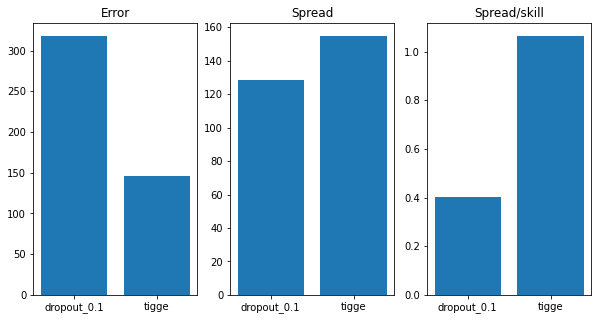

In [26]:
# I like plotting everything instead of just looking at numbers
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
ax1.bar(['dropout_0.1', 'tigge'], [ds.z_500_rmse for ds in mean_error])
ax2.bar(['dropout_0.1', 'tigge'], [ds.z_500_mean_spread for ds in mean_spread])
ax3.bar(['dropout_0.1', 'tigge'], [ds1.z_500_mean_spread / ds2.z_500_rmse 
                                   for ds1, ds2 in zip(mean_spread, mean_error)])
ax1.set_title('Error')
ax2.set_title('Spread')
ax3.set_title('Spread/skill');

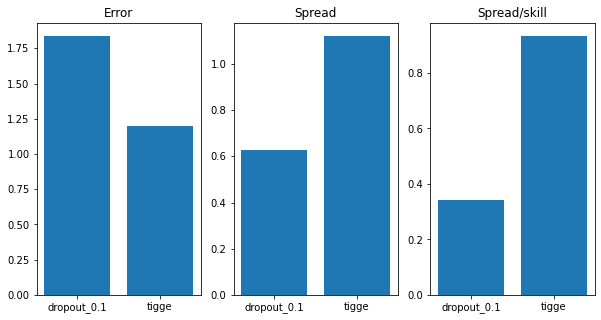

In [27]:
# I like plotting everything instead of just looking at numbers
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
ax1.bar(['dropout_0.1', 'tigge'], [ds.t_850_rmse for ds in mean_error])
ax2.bar(['dropout_0.1', 'tigge'], [ds.t_850_mean_spread for ds in mean_spread])
ax3.bar(['dropout_0.1', 'tigge'], [ds1.t_850_mean_spread / ds2.t_850_rmse 
                                   for ds1, ds2 in zip(mean_spread, mean_error)])
ax1.set_title('Error')
ax2.set_title('Spread')
ax3.set_title('Spread/skill');

So we have a much lower error for tigge and a larger spread. The spread skill for tigge is close to one, whereas for the dropout is is <0.5, so totally underdispersive.

In [69]:
mean_error.values

AttributeError: 'list' object has no attribute 'values'

In [57]:
mean_spread

[<xarray.Dataset>
 Dimensions:            ()
 Data variables:
     z_500_mean_spread  float64 128.4
     t_850_mean_spread  float64 0.6262,
 <xarray.Dataset>
 Dimensions:            ()
 Coordinates:
     isobaricInhPa      int64 500
     step               timedelta64[ns] 3 days
 Data variables:
     z_500_mean_spread  float64 154.8
     t_850_mean_spread  float64 1.121]

In [66]:
print(
mean_spread[0].z_500_mean_spread/mean_error[0].z_500_rmse #dropout
,mean_spread[0].t_850_mean_spread/mean_error[0].t_850_rmse

,mean_spread[1].z_500_mean_spread/mean_error[1].z_500_rmse #tigge
,mean_spread[1].z_500_mean_spread/mean_error[1].z_500_rmse)

<xarray.DataArray ()>
array(0.40383745) <xarray.DataArray ()>
array(0.34083753) <xarray.DataArray ()>
array(1.064081)
Coordinates:
    isobaricInhPa  int64 500
    step           timedelta64[ns] 3 days <xarray.DataArray ()>
array(1.064081)
Coordinates:
    isobaricInhPa  int64 500
    step           timedelta64[ns] 3 days


# Method 2: CRPS

In [41]:
# Let's try xskillscore instead of properscoring. It seems to be more maintained.
import xskillscore as xs

In [42]:
def compute_weighted_crps(da_fc, da_true, mean_dims=xr.ALL_DIMS):
    weights_lat = np.cos(np.deg2rad(da_fc.lat))
    weights_lat /= weights_lat.mean()
    crps = xs.crps_ensemble(da_true, da_fc)
    crps = (crps * weights_lat).mean(mean_dims)
    return crps

Usually taking mean().load() will blow up the CPU RAM. This is because it will try to load all the data at once. Xarray is able to do distributed computations though using dask in the background. We can specify that the data should be treaded as separate chunks along a dimension. Then the computations will be executed for a chunk at a time. See the xarray documentation "Parallel computing" for reference.

It still uses up a lot of memory but now is manageable.

In [43]:
observation = observation.chunk({'time': 500})

In [44]:
# Unfortunately xs requires the time arrays to be equal
crps_dr = compute_weighted_crps(preds, observation.sel(time=preds.time))

In [45]:
crps_dr.load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 160.3
    t_850    float64 1.054

In [46]:
crps_tigge = compute_weighted_crps(tigge, observation.sel(time=tigge.time))

In [47]:
crps_tigge.load()

<xarray.Dataset>
Dimensions:        ()
Coordinates:
    isobaricInhPa  int64 500
    step           timedelta64[ns] 3 days
Data variables:
    z_500          float64 65.62
    t_850          float64 0.5986

So I get quite different scores from what you got before. So let's do a sanity check. First up. let's compute the mean absolute error for the ensemble mean. Then let's treat the ensemble mean as a single member. The CRPS should equal the MAE in this case.

In [48]:
ens_mean = preds.mean('member')

In [49]:
mae = compute_weighted_mae(ens_mean, observation)

In [50]:
mae.load()

<xarray.Dataset>
Dimensions:    ()
Data variables:
    z_500_mae  float64 202.0
    t_850_mae  float64 1.285

In [51]:
crps_ens_mean = compute_weighted_crps(ens_mean.expand_dims('member'), observation.sel(time=preds.time))

In [52]:
crps_ens_mean.load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 202.0
    t_850    float64 1.285

So it looks like it is correct. I would suggest using xskillscore from now on. It seems easier to use than properscoring.

# Rank Histogram

In [53]:
from ranky import rankz

In [54]:
obs_tigge=observation.sel(time=tigge.time)
obs_dr=observation.sel(time=preds.time)

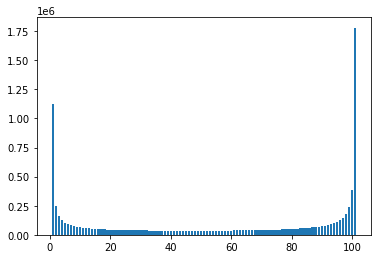

In [55]:
obs = np.asarray(obs_dr.to_array(), dtype=np.float32).squeeze();#small data
obs_z500=obs[0,...].squeeze()
obs_t850=obs[1,...].squeeze()

pred=np.asarray(preds.to_array(), dtype=np.float32).squeeze();
pred_z500=pred[0,...].squeeze() 
pred_t850=pred[1,...].squeeze() 

mask=np.ones(obs_z500.shape) #useless. #masked where 0/false.
result = rankz(obs_z500, pred_z500, mask)
plt.bar(range(1,pred_z500.shape[0]+2), result[0])
plt.show() ##overconfident (underdispersive)

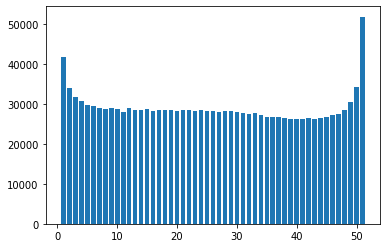

In [56]:
obs = np.asarray(obs_tigge.to_array(), dtype=np.float32).squeeze();#small data
obs_z500=obs[0,...].squeeze()
obs_t850=obs[1,...].squeeze()

pred=np.asarray(tigge.to_array(), dtype=np.float32).squeeze();
pred_z500=pred[0,...].squeeze() 
pred_t850=pred[1,...].squeeze() 

mask=np.ones(obs_z500.shape)
result = rankz(obs_z500, pred_z500, mask)
plt.bar(range(1,pred_z500.shape[0]+2), result[0])
plt.show() 

# Other visuals

In [ ]:
_=plt.hist(preds.t_850.isel(lat=20,lon=30,time=2), bins='auto')
plt.show()

In [ ]:
_=plt.hist(tigge.t_850.isel(lat=20,lon=30,time=2), bins='auto')

In [ ]:
mean_spread = []

weights_lat = np.cos(np.deg2rad(var1.lat))
weights_lat /= weights_lat.mean()
for ds in [tigge,preds]:
    var1=ds.var('member')
    mean_spread.append(np.sqrt((var1*weights_lat).mean('time')))

In [ ]:
mean_spread[0].z_500.mean().values, mean_spread[1].z_500.mean().values

In [ ]:
plt1=mean_spread[0].z_500.plot() #tigge

In [ ]:
mean_spread[1].z_500.plot() #why are they good on 80,-80 lat?

In [ ]:
mean_spread[0].t_850.plot()

# Old stuff

In [ ]:
#check if xs and ps package give same results. should be.

In [ ]:
# #Method 3: Rank Histogram
# # !pip install rank-histogram
# # R code: https://rdrr.io/cran/SpecsVerification/src/R/Rankhist.R
# from ranky import rankz

# #obs = np.asarray(observation.to_array(), dtype=np.float32).squeeze(); #Full data. #DOES NOT WORK if dimensions dont match
# obs = np.asarray(obs2.to_array(), dtype=np.float32).squeeze();#small data

# obs_z500=obs[0,...].squeeze()
# obs_t850=obs[1,...].squeeze()

# pred=np.asarray(preds.to_array(), dtype=np.float32).squeeze();
# pred_z500=pred[0,...].squeeze() 
# pred_t850=pred[1,...].squeeze() 

# mask=np.ones(obs_z500.shape) #useless. #masked where 0/false.
# # feed into rankz function
# result = rankz(obs_z500, pred_z500, mask)
# # plot histogram
# plt.bar(range(1,pred_z500.shape[0]+2), result[0])
# # view histogram
# plt.show() ##overconfident (underdispersive)

In [ ]:
# #For Temperature. Should be better. (OLD)
# result = rankz(obs_t850, pred_t850, mask)
# # plot histogram
# plt.bar(range(1,pred_t850.shape[0]+2), result[0])
# # view histogram
# plt.show() ##overconfident (underdispersive)

In [ ]:
#old code. ignore.

In [ ]:
# #result from old code with 50 forecasts. just to show it is still overconfident
# result = rankz(obs_t850, pred_t850, mask)
# plt.bar(range(1,pred_t850.shape[0]+2), result[0])
# plt.show()

In [ ]:
# #sanity check: for a random sample
# obs = np.random.randn(10, 40, 40)
# ensemble = np.random.randn(20, 10, 40, 40)
# mask = np.random.randint(0, 2, (10, 40, 40)) #masked where 0/false.
# # feed into rankz function
# result = rankz(obs, ensemble, mask)
# # plot histogram
# plt.bar(range(1,ensemble.shape[0]+2), result[0])
# # view histogram
# plt.show()

In [ ]:
# #testing for smaller number of bins (i.e. forecasts) (For old predictions.)
# obs_small=obs_z500[:,:,:].squeeze()
# pred_small=pred_z500[0:10,:,:,:]
# mask=np.ones(obs_small.shape).squeeze()
# print(obs_small.shape)
# print(pred_small.shape)
# print(mask.shape)

# result = rankz(obs_small, pred_small, mask)
# plt.bar(range(1,pred_small.shape[0]+2), result[0])
# plt.show() #overconfident (underdispersive)